# Packages

In [329]:
import pandas as pd
!pip install xlrd
import mimetypes
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import QuarterEnd
import pandas_datareader.data as web
import networkx as nx

# ID Industries/Sectors

In [330]:
print(mimetypes.guess_type('oes_research_2024_allsectors.xlsx'))

('application/vnd.openxmlformats-officedocument.spreadsheetml.sheet', None)


In [331]:
file_path = '/content/Book 1.xlsx'
df = pd.read_excel(file_path)

In [332]:
print(df.head())
print(df.columns)

                                   Industry sector 2022 NAICS  \
0                                 Total employment          –   
1                            Self-employed workers          –   
2                 Total wage and salary employment          –   
3      Agriculture, forestry, fishing, and hunting         11   
4                                   Nonagriculture          –   

   Employment, 2013  Employment, 2023  Employment, 2033  \
0          147671.6          167849.8          174589.0   
1            9391.0            9708.9            9828.8   
2          138280.6          158140.9          164760.3   
3            1243.2            1461.8            1473.0   
4          137037.4          156679.1          163287.3   

   Employment change, 2013–23  Employment change, numeric, 2023–33  \
0                     20274.9                               6739.2   
1                       414.6                                119.9   
2                     19860.3               

In [333]:
mask = ~df['Industry sector'].str.lower().str.contains('total|self-employed|nonagriculture', na=False)
industry_df = df[mask]

In [334]:
# Drop any rows without a value for 2023 employment
industry_df = industry_df.dropna(subset=['Employment, 2023'])

# Sort and select top 5
top5 = industry_df.sort_values('Employment, 2023', ascending=False).head(5)[['Industry sector', 'Employment, 2023']]

# Reset the index for a clean output
top5 = top5.reset_index(drop=True)

print(top5)

                                     Industry sector  Employment, 2023
0        Service-providing, excluding special ind...          135126.4
1                 Professional and business services           22840.1
2        Goods-producing, excluding agriculture a...           21552.7
3          Healthcare and social assistance; private           21524.5
4                         State and local government           19856.6


#Employment

In [335]:
fred_emp_series = {
    'Healthcare': {'emp': 'CES6562000001'},
    'Prof/Bus': {'emp': 'USPBS'},
    'State Govt': {'emp': 'CES9092000001'},
    'Local Govt': {'emp': 'CES9093000001'},
    'Mfg': {'emp': 'MANEMP'},
    'Service': {'emp': 'SRVPRD'}
}

start_date = '2000-01-01'
end_date = '2025-04-30'

df = pd.DataFrame()

for sector, codes in fred_emp_series.items():
    series = codes['emp']
    df[sector] = pdr.DataReader(series, 'fred', start_date, end_date)

# Change to Quarterly
df_q = df.resample('Q').mean()

# Drop quarters with all NaNs (if any)
df_q.dropna(how='all', inplace=True)

df_q.tail()

<ipython-input-335-d73f3dcb4068>:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_q = df.resample('Q').mean()


,Healthcare,Prof/Bus,State Govt,Local Govt,Mfg,Service
DATE,,,,,,
2024-06-30,22432.366667,22646.666667,5422.333333,14899.000000,12845.000000,136134.000000
2024-09-30,22630.466667,22596.333333,5455.000000,14968.333333,12813.333333,136454.666667
2024-12-31,22862.466667,22577.666667,5496.333333,15023.333333,12760.000000,136978.666667
2025-03-31,23065.200000,22590.000000,5518.000000,15070.666667,12761.333333,137501.666667
2025-06-30,23194.000000,22614.000000,5522.000000,15101.000000,12765.000000,137811.000000


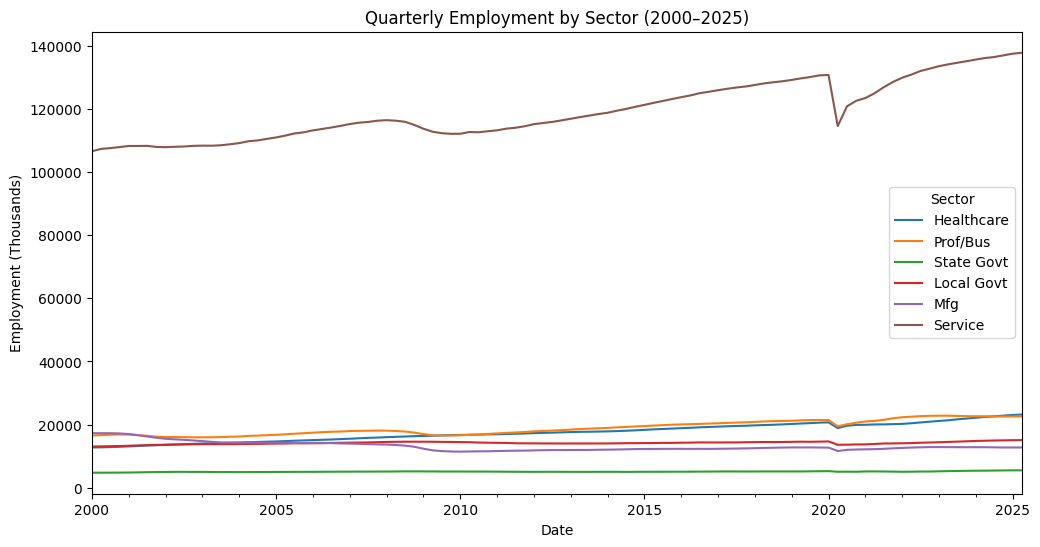

In [336]:
df_q.plot(figsize=(12,6))
plt.title("Quarterly Employment by Sector (2000–2025)")
plt.ylabel("Employment (Thousands)")
plt.xlabel("Date")
plt.legend(title="Sector")
plt.show()

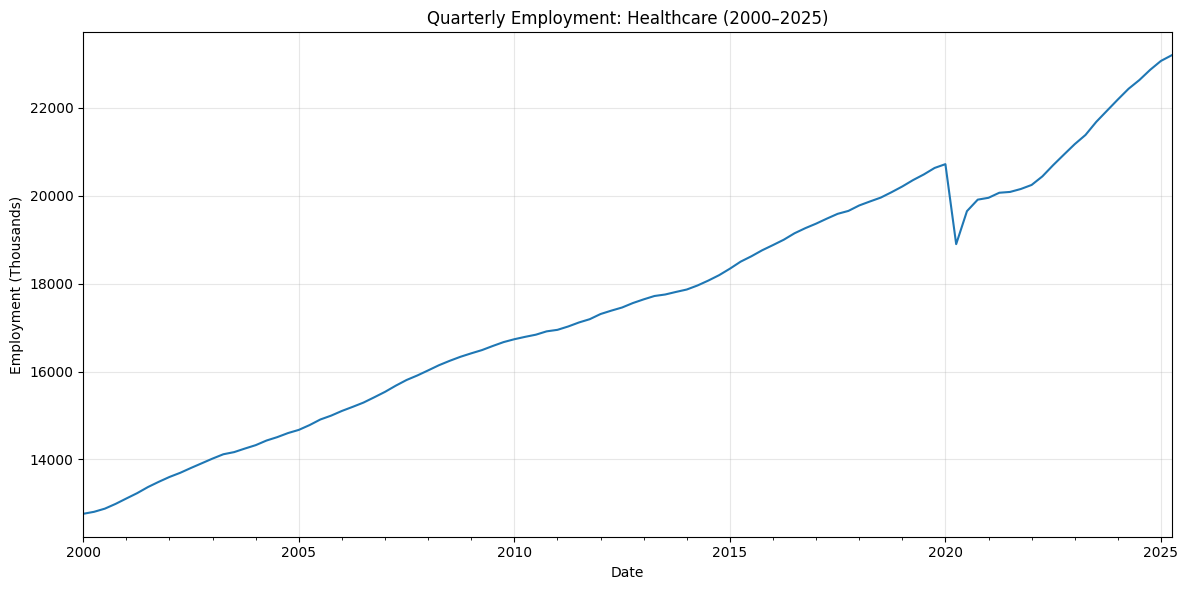

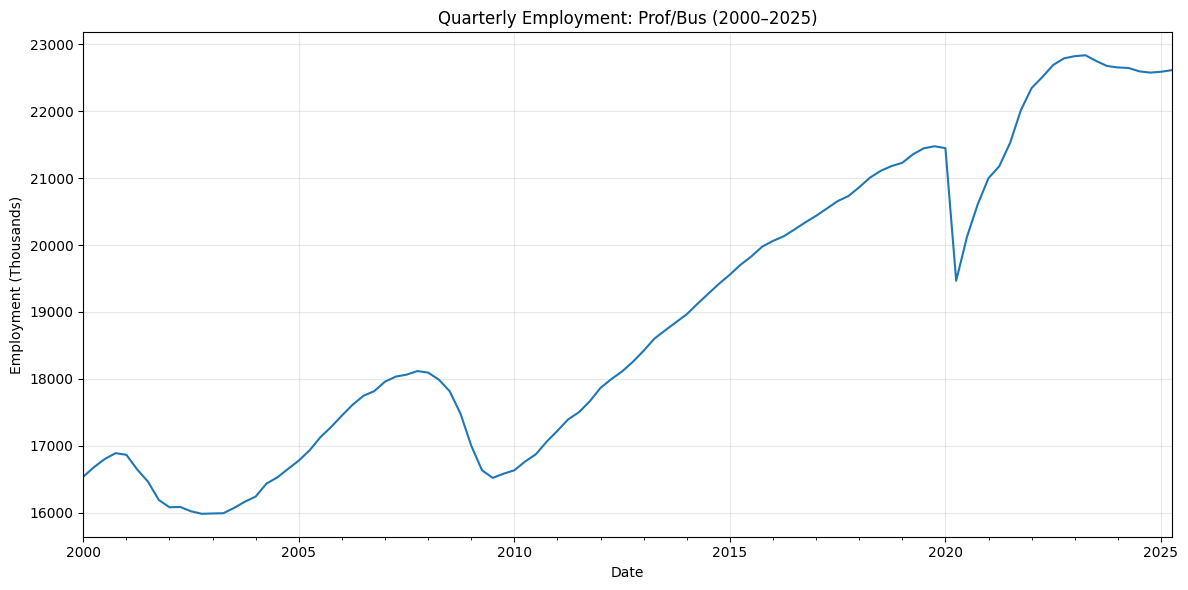

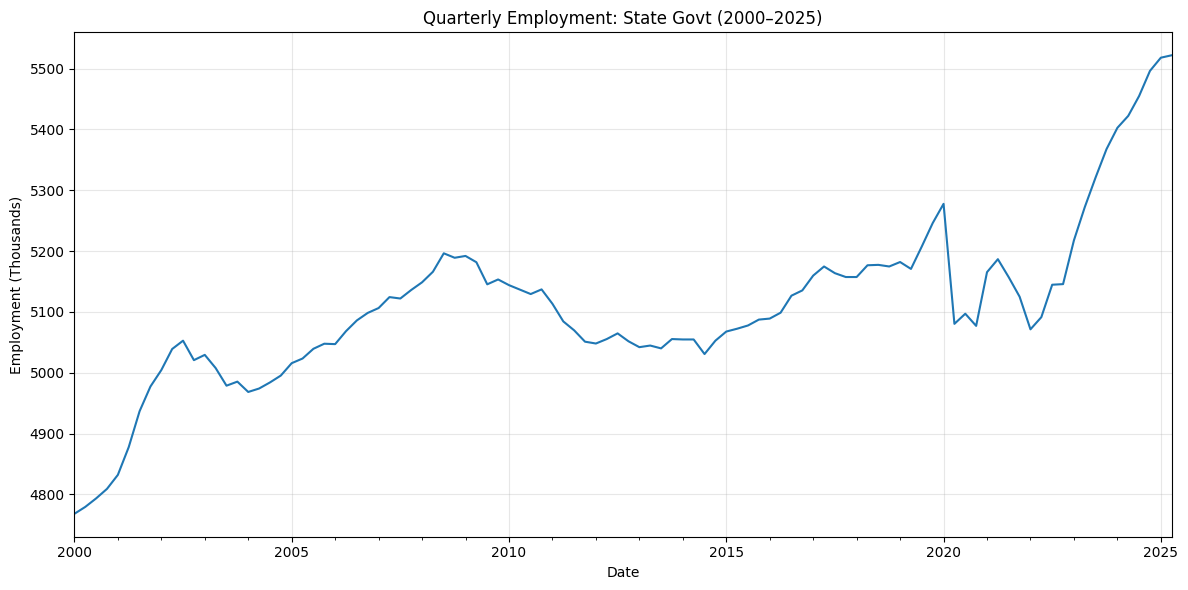

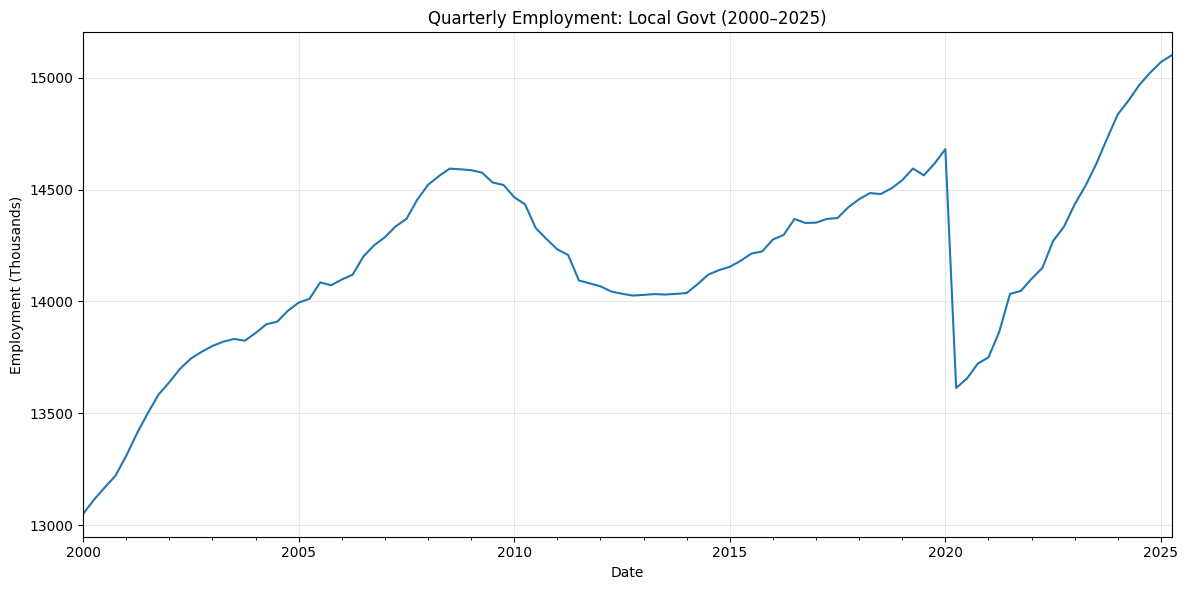

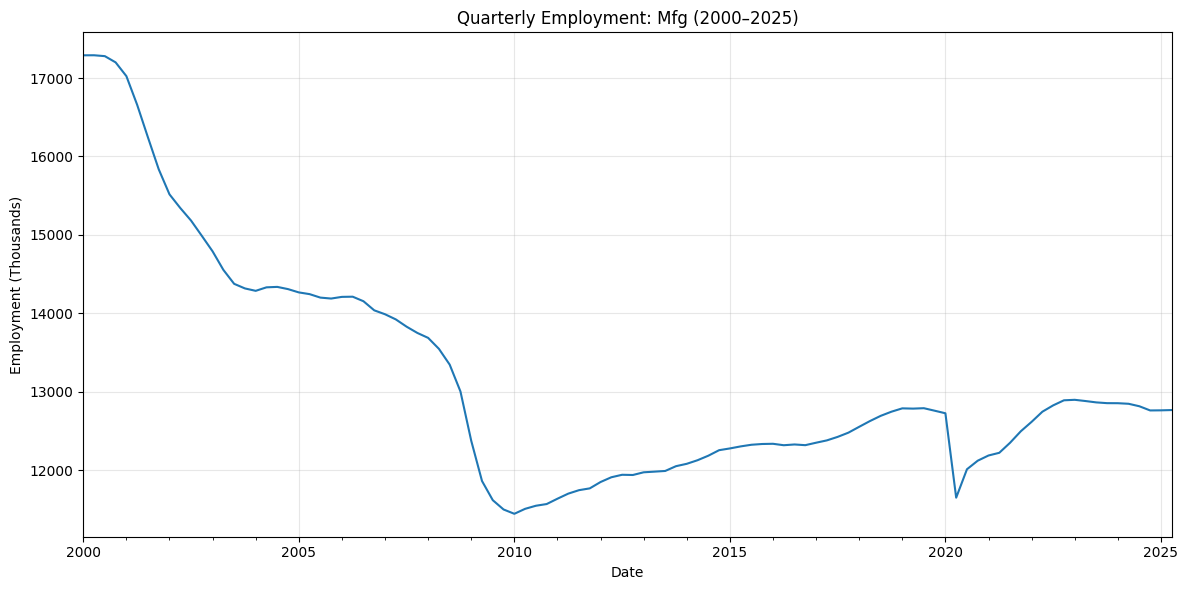

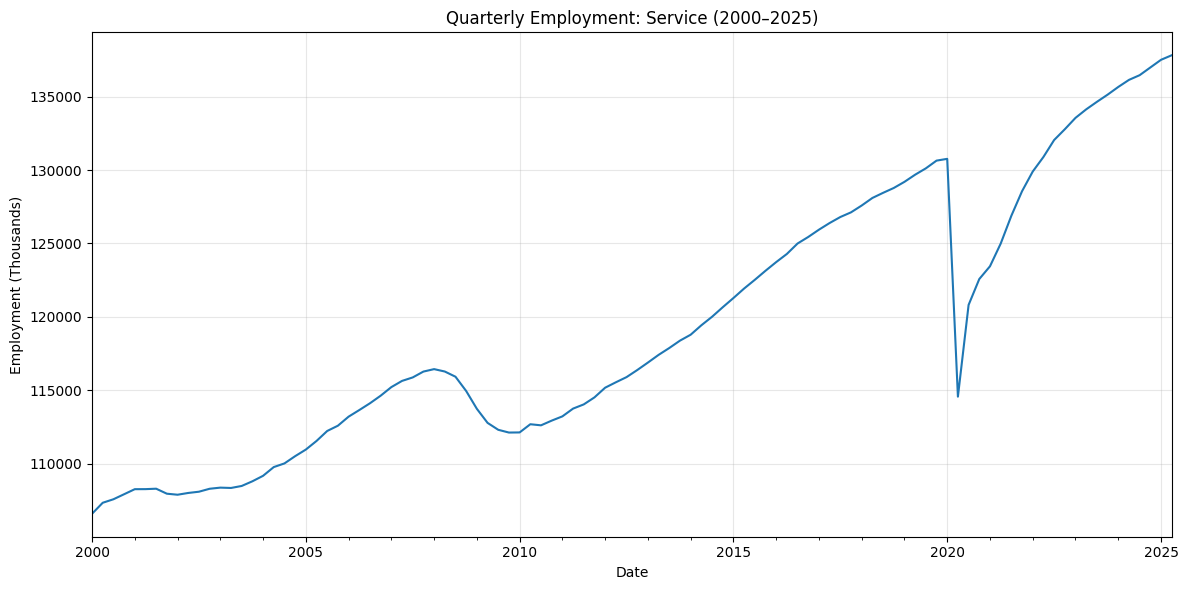

In [337]:
for sector in df_q.columns:
    plt.figure(figsize=(12,6))
    df_q[sector].plot()
    plt.title(f"Quarterly Employment: {sector} (2000–2025)")
    plt.ylabel("Employment (Thousands)")
    plt.xlabel("Date")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [338]:
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"{name}: ADF Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}")

print("ADF Test Results (Quarterly):")
for sector in df_q.columns:
    adf_test(df_q[sector], sector)

ADF Test Results (Quarterly):
Healthcare: ADF Statistic = 0.5809, p-value = 0.9871
Prof/Bus: ADF Statistic = 0.0814, p-value = 0.9648
State Govt: ADF Statistic = -0.5056, p-value = 0.8909
Local Govt: ADF Statistic = -1.9172, p-value = 0.3240
Mfg: ADF Statistic = -3.5544, p-value = 0.0067
Service: ADF Statistic = -0.0962, p-value = 0.9498


In [339]:
df_q_trans = pd.DataFrame(index=df_q.index)

for sector in df_q.columns:
    s = df_q[sector]
    # Log transformation
    s_log = np.log(s) if (s > 0).all() else s
    df_q_trans[sector] = s_log.diff()

df_q_trans.dropna(inplace=True)

# Re-run ADF
print("\nADF After Transformation:")
for sector in df_q_trans.columns:
    adf_test(df_q_trans[sector], sector)


ADF After Transformation:
Healthcare: ADF Statistic = -12.2550, p-value = 0.0000
Prof/Bus: ADF Statistic = -8.2060, p-value = 0.0000
State Govt: ADF Statistic = -3.4744, p-value = 0.0087
Local Govt: ADF Statistic = -9.4256, p-value = 0.0000
Mfg: ADF Statistic = -4.4378, p-value = 0.0003
Service: ADF Statistic = -12.3276, p-value = 0.0000


In [340]:
model = VAR(df_q_trans)
lag_order_results = model.select_order(maxlags=8)
print(lag_order_results.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -63.84      -63.68   1.880e-28      -63.77
1      -67.92     -66.77*   3.202e-30     -67.45*
2      -68.06      -65.94   2.789e-30      -67.21
3      -68.23      -65.13   2.407e-30      -66.98
4      -68.61      -64.52   1.736e-30      -66.96
5      -68.54      -63.47   2.007e-30      -66.49
6      -69.01      -62.97  1.413e-30*      -66.57
7      -69.06      -62.04   1.600e-30      -66.23
8     -69.11*      -61.10   1.962e-30      -65.88
-------------------------------------------------


In [341]:
optimal_lag = lag_order_results.aic
var_model = model.fit(optimal_lag)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 29, May, 2025
Time:                     19:07:22
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -61.1048
Nobs:                     93.0000    HQIC:                  -65.8784
Log likelihood:           2715.90    FPE:                1.96155e-30
AIC:                     -69.1111    Det(Omega_mle):     1.54799e-31
--------------------------------------------------------------------
Results for equation Healthcare
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.006869         0.006023            1.141           0.254
L1.Healthcare         1.459136         1.650228            0.884           0.377
L1.Prof/Bus           0.916600         0.918244        

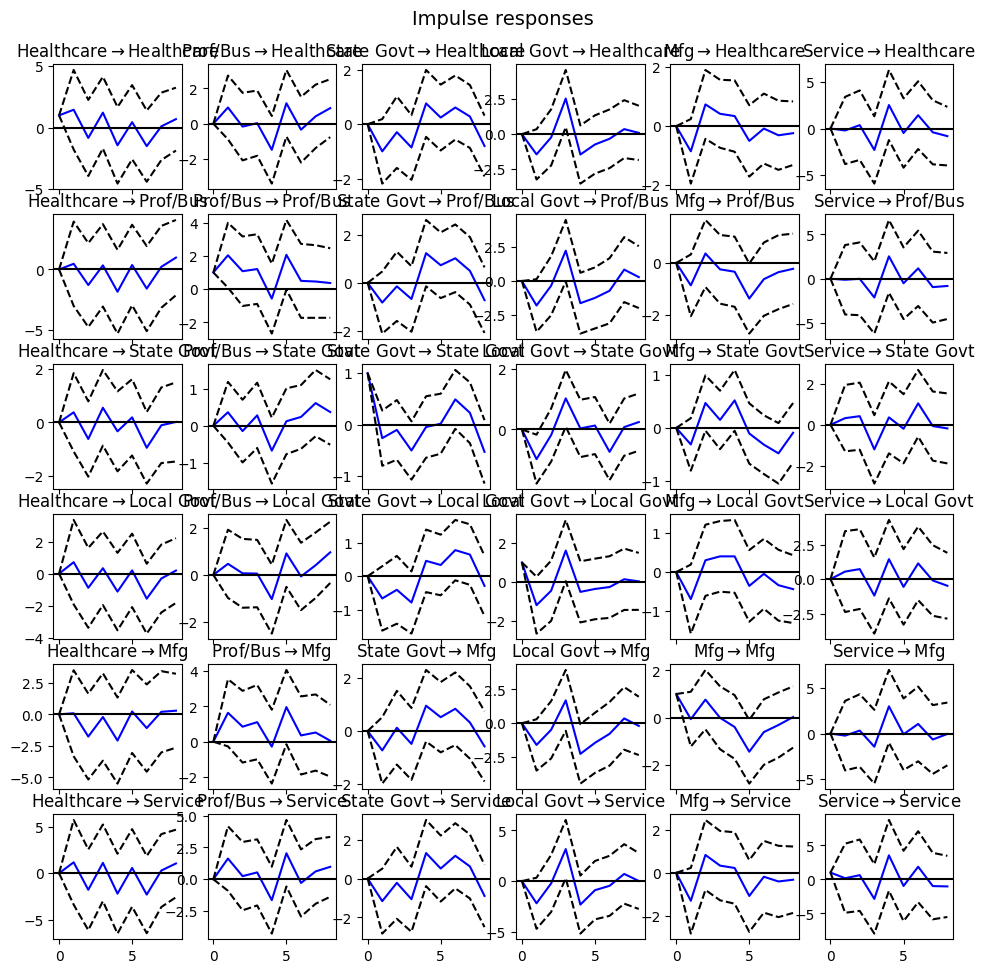

In [342]:
irf = var_model.irf(8)
irf.plot(orth=False)
plt.show()

In [343]:
forecast_steps = 8
forecast = var_model.forecast(df_q_trans.values[-optimal_lag:], steps=forecast_steps)
forecast_index = pd.date_range(start=df_q_trans.index[-1] + pd.offsets.QuarterEnd(), periods=forecast_steps, freq='Q')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=df_q_trans.columns)

<ipython-input-343-88b80792d736>:3: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_index = pd.date_range(start=df_q_trans.index[-1] + pd.offsets.QuarterEnd(), periods=forecast_steps, freq='Q')


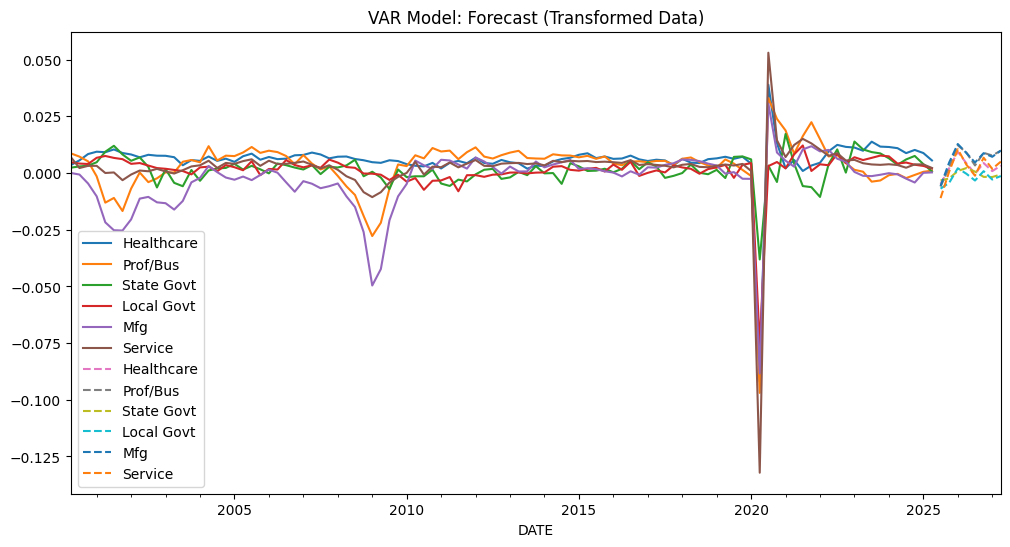

In [344]:
ax = df_q_trans.plot(figsize=(12,6))
forecast_df.plot(ax=ax, linestyle='--', legend=True)
plt.title("VAR Model: Forecast (Transformed Data)")
plt.show()

In [345]:
arima_forecasts = {}

for sector in df_q_trans.columns:
    series = df_q_trans[sector].dropna()
    arima_model = ARIMA(series, order=(1,0,0))
    arima_fit = arima_model.fit()
    arima_forecasts[sector] = arima_fit.forecast(steps=forecast_steps)

arima_forecast_df = pd.DataFrame(arima_forecasts, index=forecast_index)


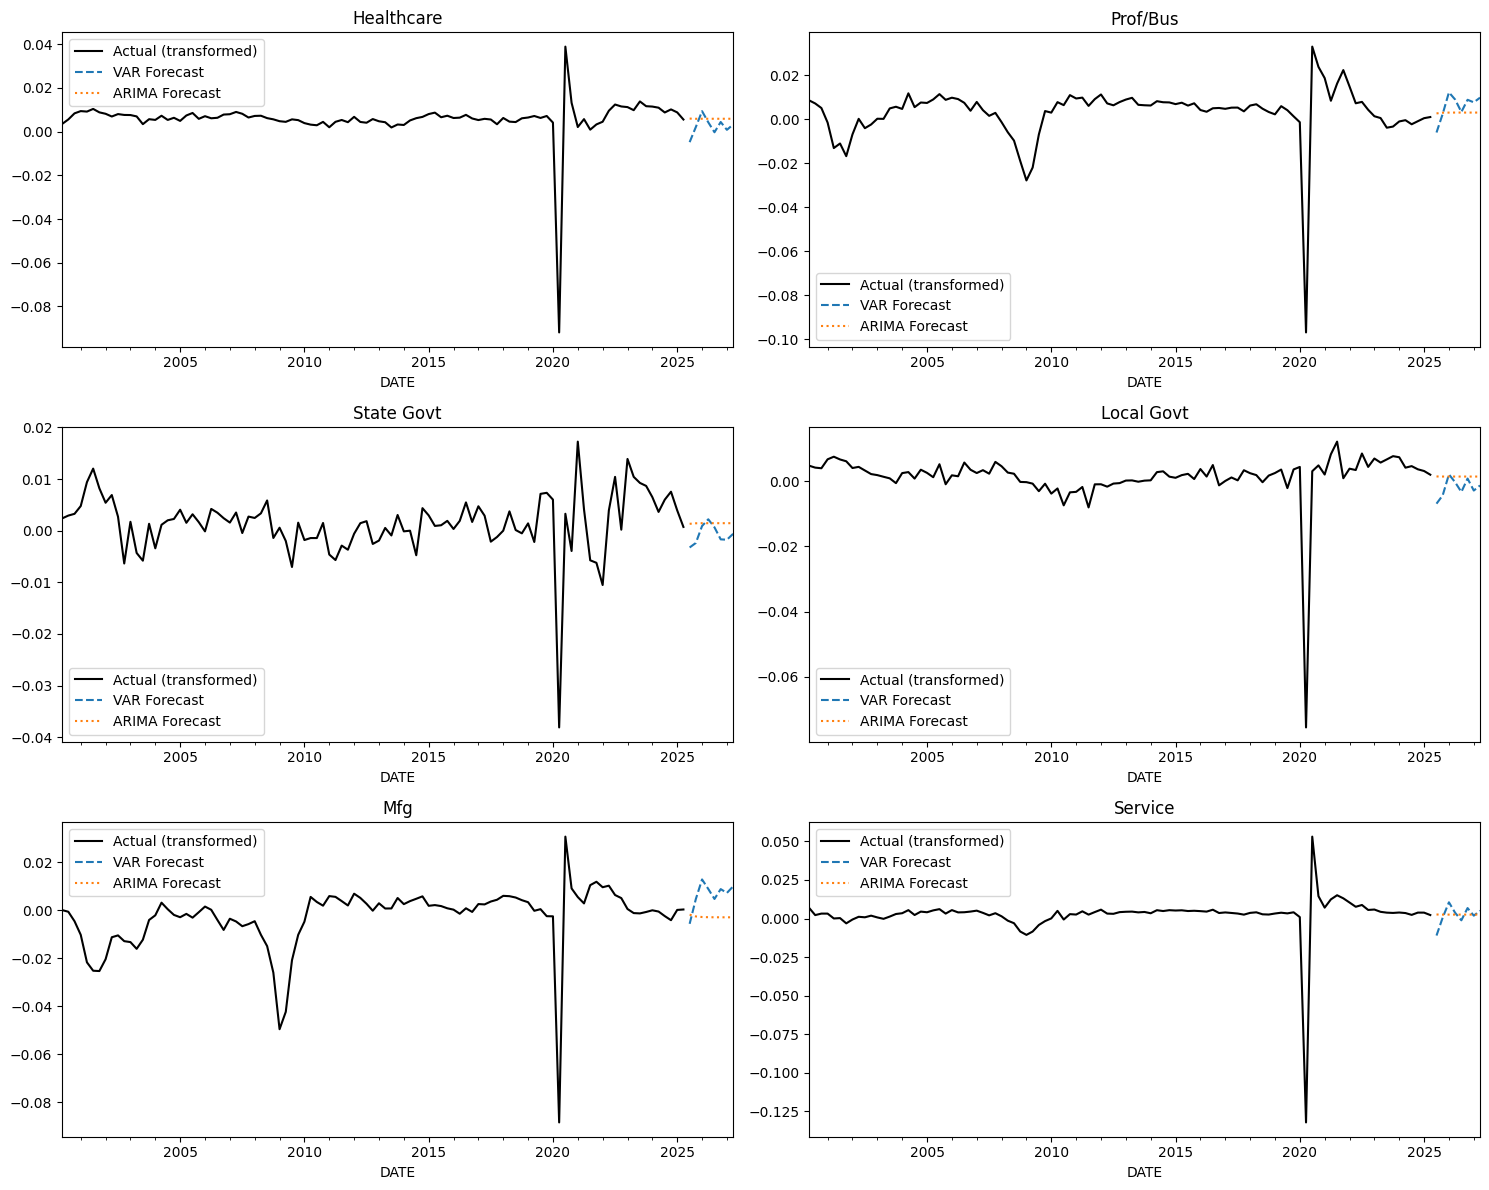

In [346]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axes = axes.flatten()

for i, sector in enumerate(df_q_trans.columns):
    ax = axes[i]
    df_q_trans[sector].plot(ax=ax, label='Actual (transformed)', color='black')
    forecast_df[sector].plot(ax=ax, label='VAR Forecast', linestyle='--')
    arima_forecast_df[sector].plot(ax=ax, label='ARIMA Forecast', linestyle=':')
    ax.set_title(sector)
    ax.legend()

plt.tight_layout()
plt.show()

# Wages

In [347]:
fred_wage_series = {
    'Healthcare': {'wage': 'CES6500000011'},
    'Prof/Bus': {'wage': 'CES6000000011'},
    'State/Local Govt': {'wage': 'ECIGVTWAG'},
    'Mfg': {'wage': 'CES3000000003'},
    'Service': {'wage': 'CES8000000003'}
}

cpi_series = 'CPIAUCSL'
start_date = '2000-01-01'
end_date = '2025-04-30'

In [348]:
data = {}
for sector, info in fred_wage_series.items():
    data[sector] = web.DataReader(info['wage'], 'fred', start_date, end_date)
cpi = web.DataReader(cpi_series, 'fred', start_date, end_date)

In [349]:
df_wages = pd.concat(data.values(), axis=1)
df_wages.columns = data.keys()

In [350]:
df_wages = df_wages.resample('M').ffill()
cpi = cpi.resample('M').ffill()

<ipython-input-350-411d36f21fe4>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_wages = df_wages.resample('M').ffill()
<ipython-input-350-411d36f21fe4>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cpi = cpi.resample('M').ffill()


In [351]:
# Adjust to real (2025) prices
cpi_2025 = cpi.loc[end_date].values[0]
df_wages_real = df_wages.multiply(cpi_2025 / cpi['CPIAUCSL'], axis=0)

In [352]:
df_wages_real_q = df_wages_real.resample('Q').mean()

<ipython-input-352-5cd4c03758e1>:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_wages_real_q = df_wages_real.resample('Q').mean()


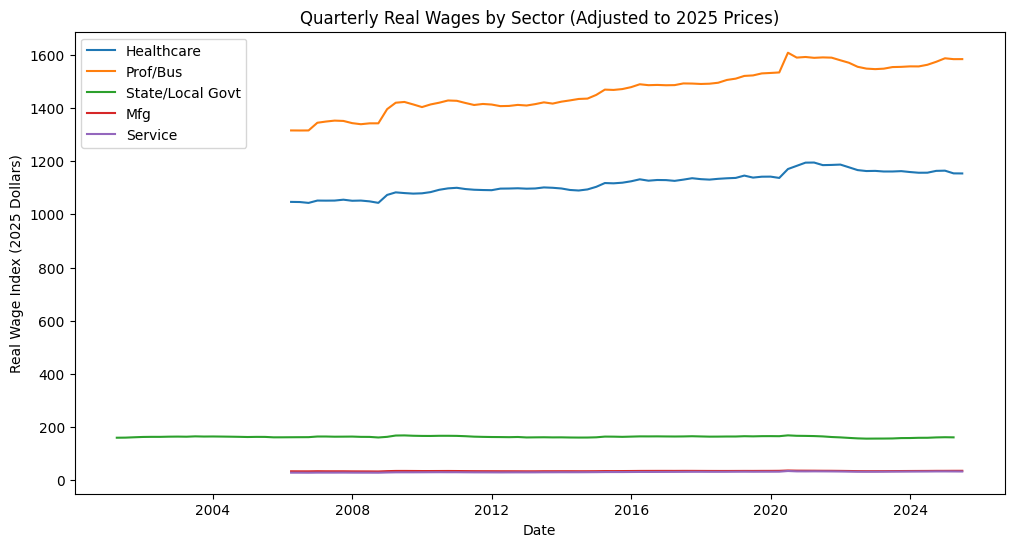

In [353]:
plt.figure(figsize=(12,6))
for sector in df_wages_real_q.columns:
    plt.plot(df_wages_real_q.index, df_wages_real_q[sector], label=sector)
plt.title("Quarterly Real Wages by Sector (Adjusted to 2025 Prices)")
plt.ylabel("Real Wage Index (2025 Dollars)")
plt.xlabel("Date")
plt.legend()
plt.show()

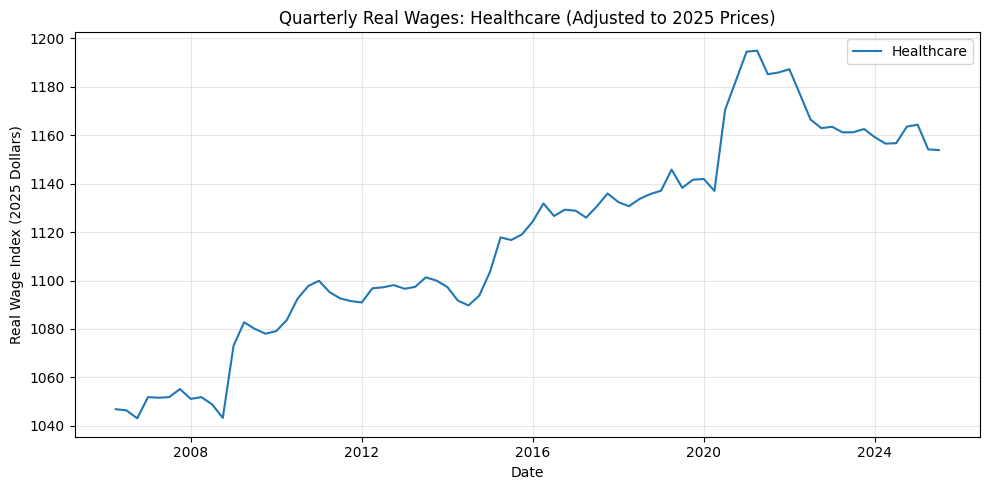

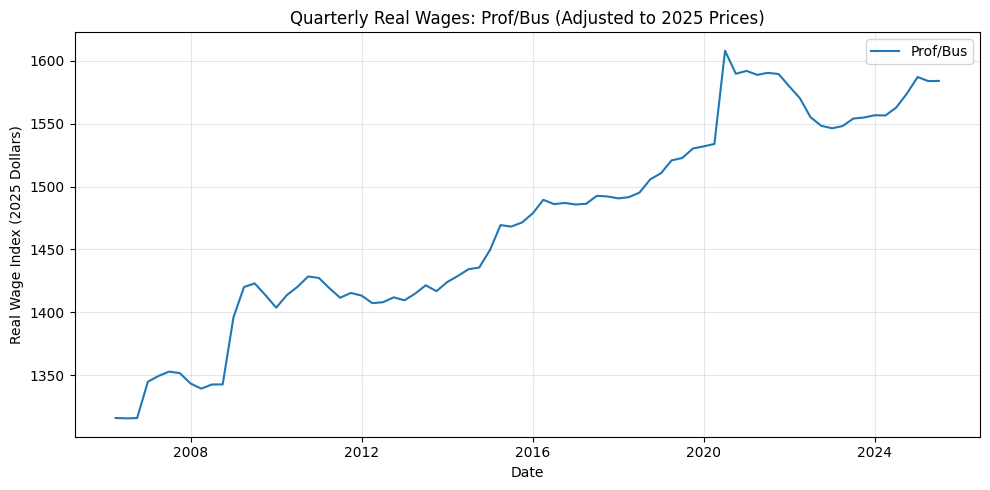

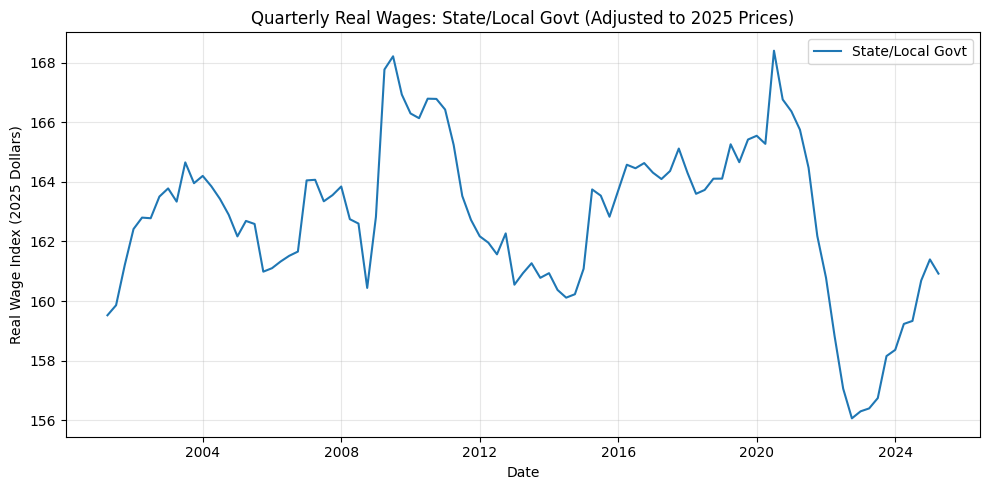

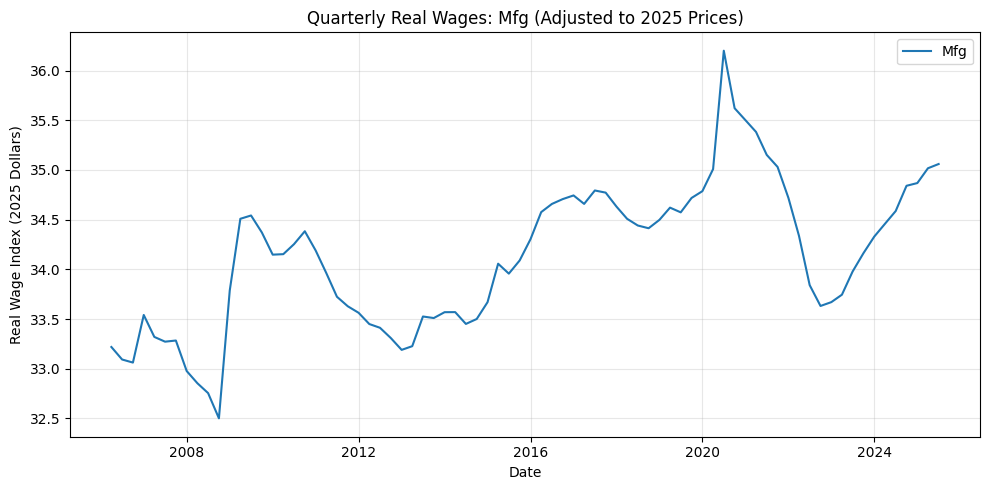

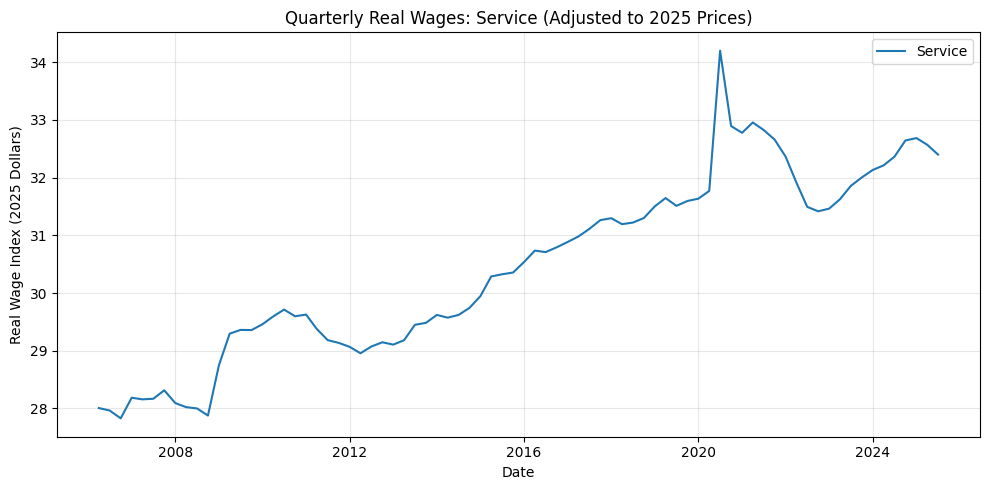

In [354]:
# Individual plots for each sector
for sector in df_wages_real_q.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(df_wages_real_q.index, df_wages_real_q[sector], label=sector, color='tab:blue')
    plt.title(f"Quarterly Real Wages: {sector} (Adjusted to 2025 Prices)")
    plt.ylabel("Real Wage Index (2025 Dollars)")
    plt.xlabel("Date")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [355]:
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Test for {title}')
    print(f'  Test Statistic: {result[0]:.4f}')
    print(f'  p-value: {result[1]:.4f}')
    if result[1] < 0.05:
        print("  => Series is stationary")
    else:
        print("  => Series is NOT stationary")
    print()

# Test for stationarity and transform
transformed = {}
for sector in df_wages_real_q.columns:
    print("="*40)
    adf_test(df_wages_real_q[sector], title=sector)
    # log transformation
    log_series = np.log(df_wages_real_q[sector])
    adf_test(log_series, title=f"{sector} (log)")
    # log-differenced
    log_diff = log_series.diff().dropna()
    adf_test(log_diff, title=f"{sector} (log-diff)")
    transformed[sector] = log_diff

ADF Test for Healthcare
  Test Statistic: -1.5572
  p-value: 0.5051
  => Series is NOT stationary

ADF Test for Healthcare (log)
  Test Statistic: -1.5901
  p-value: 0.4886
  => Series is NOT stationary

ADF Test for Healthcare (log-diff)
  Test Statistic: -7.3696
  p-value: 0.0000
  => Series is stationary

ADF Test for Prof/Bus
  Test Statistic: -1.2847
  p-value: 0.6362
  => Series is NOT stationary

ADF Test for Prof/Bus (log)
  Test Statistic: -1.4203
  p-value: 0.5725
  => Series is NOT stationary

ADF Test for Prof/Bus (log-diff)
  Test Statistic: -8.0357
  p-value: 0.0000
  => Series is stationary

ADF Test for State/Local Govt
  Test Statistic: -2.7268
  p-value: 0.0695
  => Series is NOT stationary

ADF Test for State/Local Govt (log)
  Test Statistic: -2.7206
  p-value: 0.0705
  => Series is NOT stationary

ADF Test for State/Local Govt (log-diff)
  Test Statistic: -7.6629
  p-value: 0.0000
  => Series is stationary

ADF Test for Mfg
  Test Statistic: -2.2502
  p-value: 0.18

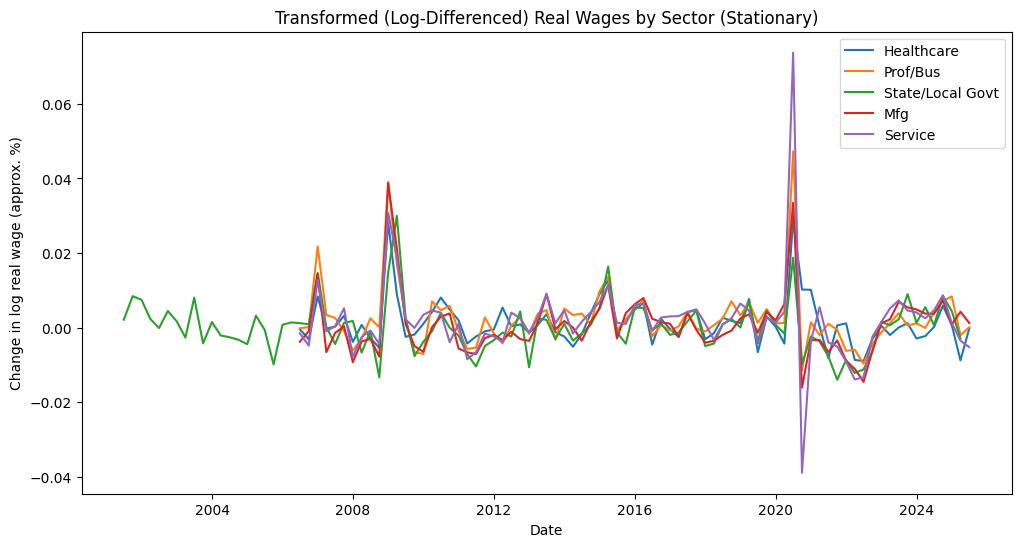

In [356]:
plt.figure(figsize=(12,6))
for sector in transformed:
    plt.plot(transformed[sector].index, transformed[sector], label=sector)
plt.title("Transformed (Log-Differenced) Real Wages by Sector (Stationary)")
plt.ylabel("Change in log real wage (approx. %)")
plt.xlabel("Date")
plt.legend()
plt.show()

In [357]:
df_wages_real_q["State/Local Govt"] = df_wages_real_q["State/Local Govt"].ffill()

In [358]:
df_wages_log = np.log(df_wages_real_q)
df_wages_logdiff = df_wages_log.diff().dropna()

In [359]:
df_var = df_wages_logdiff.dropna()

In [360]:
model = VAR(df_var)
lag_order_results = model.select_order(maxlags=8)
print(lag_order_results.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -53.02     -52.86*   9.393e-24      -52.96
1     -53.74*      -52.77  4.597e-24*     -53.35*
2      -53.68      -51.90   4.952e-24      -52.97
3      -53.49      -50.90   6.156e-24      -52.46
4      -53.60      -50.20   5.812e-24      -52.25
5      -53.16      -48.95   9.953e-24      -51.49
6      -53.04      -48.02   1.304e-23      -51.05
7      -53.58      -47.75   9.538e-24      -51.26
8      -53.65      -47.01   1.238e-23      -51.01
-------------------------------------------------


In [361]:
best_lag = lag_order_results.aic
print(f"Best lag length by AIC: {best_lag}")

Best lag length by AIC: 1


In [362]:
var_results = model.fit(best_lag)
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 29, May, 2025
Time:                     19:07:44
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -52.7681
Nobs:                     76.0000    HQIC:                  -53.3204
Log likelihood:           1530.95    FPE:                4.83363e-24
AIC:                     -53.6881    Det(Omega_mle):     3.30577e-24
--------------------------------------------------------------------
Results for equation Healthcare
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.000658         0.000799            0.823           0.410
L1.Healthcare               0.077021         0.180616            0.426           0.670
L1.Prof/Bus                 0.1

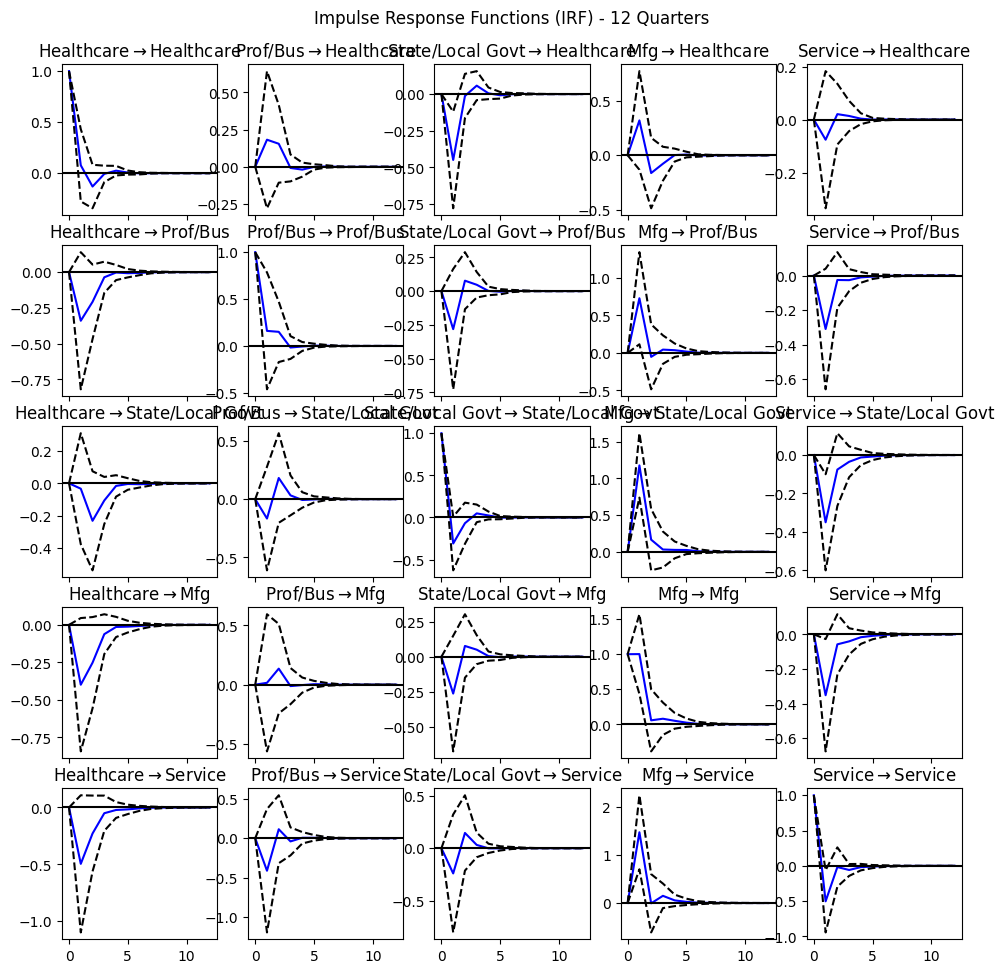

In [363]:
irf = var_results.irf(12)
irf.plot(orth=False)
plt.suptitle("Impulse Response Functions (IRF) - 12 Quarters")
plt.show()

In [364]:
n_forecast = 8
lagged_vals = df_var.values[-best_lag:]
forecast_logdiff = var_results.forecast(lagged_vals, steps=n_forecast)

In [365]:
forecast_index = pd.date_range(df_var.index[-1] + pd.offsets.QuarterEnd(1), periods=n_forecast, freq='Q')
forecast_logdiff_df = pd.DataFrame(forecast_logdiff, index=forecast_index, columns=df_var.columns)

<ipython-input-365-c9585119713b>:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_index = pd.date_range(df_var.index[-1] + pd.offsets.QuarterEnd(1), periods=n_forecast, freq='Q')


In [366]:
last_log = df_wages_log.iloc[-1]
forecast_log_levels = forecast_logdiff_df.cumsum()
forecast_log_levels = forecast_log_levels.add(last_log, axis='columns')

In [367]:
forecast_real_levels = np.exp(forecast_log_levels)

In [368]:
full_series = pd.concat([df_wages_real_q, forecast_real_levels])

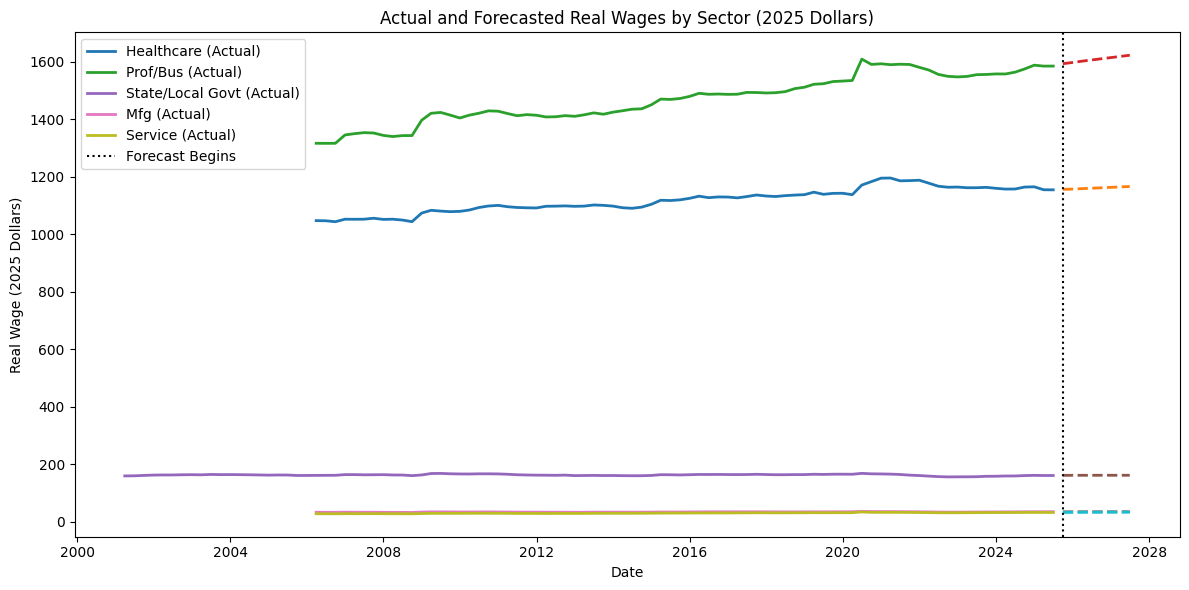

In [369]:
plt.figure(figsize=(12, 6))

for col in full_series.columns:
    actual = full_series.loc[:forecast_real_levels.index[0]-pd.offsets.QuarterEnd(1), col]
    forecast = full_series.loc[forecast_real_levels.index[0]:, col]
    plt.plot(actual.index, actual.values, label=f"{col} (Actual)", linewidth=2)
    plt.plot(forecast.index, forecast.values, linestyle='--', linewidth=2)

plt.axvline(x=forecast_real_levels.index[0], color='k', linestyle=':', linewidth=1.5, label='Forecast Begins')

plt.title("Actual and Forecasted Real Wages by Sector (2025 Dollars)")
plt.xlabel("Date")
plt.ylabel("Real Wage (2025 Dollars)")
plt.legend()
plt.tight_layout()
plt.show()

# Diebold-Yimaz Index: Employemnt

In [370]:
def diebold_yilmaz_index(var_results, horizon=10):
    K = var_results.neqs
    Phi = var_results.ma_rep(horizon)
    Sigma_u = var_results.sigma_u
    fevd = np.zeros((K, K))
    for j in range(K):
        e_j = np.zeros(K)
        e_j[j] = 1.0
        for i in range(K):
            num = 0.0
            den = 0.0
            for h in range(1, horizon+1):
                contrib = np.dot(Phi[h, i, :], np.dot(Sigma_u, e_j))
                num += (contrib)**2
                den += np.dot(Phi[h, i, :], np.dot(Sigma_u, Phi[h, i, :].T))
            fevd[i, j] = num / den if den > 0 else 0
    fevd = np.abs(fevd)
    fevd = fevd / fevd.sum(axis=1, keepdims=True)
    return fevd

In [371]:
def spillover_index(fevd):
    K = fevd.shape[0]
    off_diag_sum = fevd.sum() - np.trace(fevd)
    S = 100 * off_diag_sum / K
    return S

In [372]:
def rolling_dy_index(data, window=40, horizon=10, maxlags=4):
    dy_indices = []
    dy_dates = []
    fevd_matrices = []
    for start in range(0, len(data) - window + 1):
        window_data = data.iloc[start:start+window]
        model = VAR(window_data)
        try:
            res = model.fit(maxlags)
            fevd = diebold_yilmaz_index(res, horizon=horizon)
            dy = spillover_index(fevd)
        except Exception as e:
            fevd = np.full((data.shape[1], data.shape[1]), np.nan)
            dy = np.nan
        dy_indices.append(dy)
        fevd_matrices.append(fevd)
        dy_dates.append(window_data.index[-1])
    return pd.Series(dy_indices, index=dy_dates), fevd_matrices

In [373]:
dy_series, fevd_matrices = rolling_dy_index(df_q_trans, window=40, horizon=10, maxlags=4)

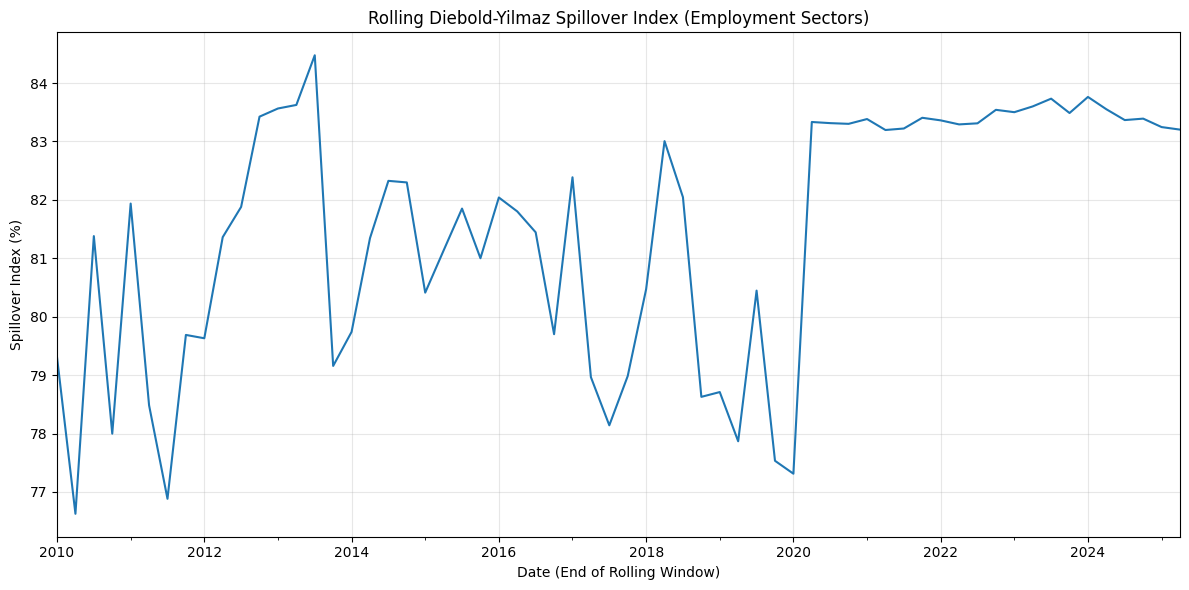

In [374]:
plt.figure(figsize=(12, 6))
dy_series.plot()
plt.title("Rolling Diebold-Yilmaz Spillover Index (Employment Sectors)")
plt.ylabel("Spillover Index (%)")
plt.xlabel("Date (End of Rolling Window)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [375]:
def plot_spillover_network(fevd, labels, threshold=0.02):
    """
    fevd: K x K spillover matrix (as % or proportion, off-diagonals)
    labels: list of sector names
    threshold: minimum weight (proportion) to show edge
    """
    K = fevd.shape[0]
    G = nx.DiGraph()
    for i in range(K):
        G.add_node(labels[i])
    for i in range(K):
        for j in range(K):
            if i != j and fevd[i, j] >= threshold:
                G.add_edge(labels[j], labels[i], weight=fevd[i, j])
    weights = [G[u][v]['weight']*8 for u, v in G.edges()]
    pos = nx.circular_layout(G)
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=9000, arrowsize=25,
            edge_color='gray', width=weights, font_size=13, font_weight='bold')
    edge_labels = {(u, v): f"{100*G[u][v]['weight']:.1f}%" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title("Employment Spillover Network (Latest Rolling Window)")
    plt.tight_layout()
    plt.show()


In [376]:
labels = df_q_trans.columns.tolist()
latest_fevd = fevd_matrices[-1]

<ipython-input-375-6ba30106b8f1>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


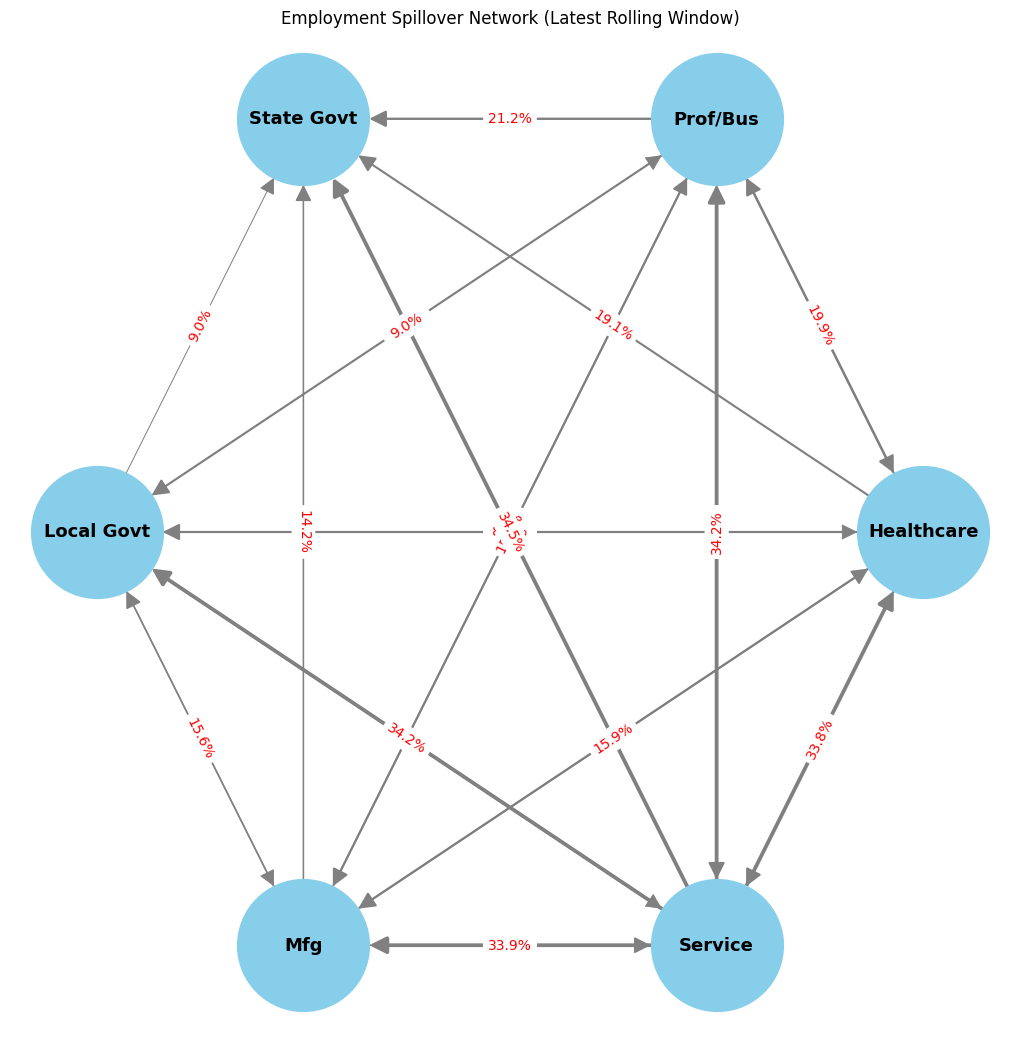

In [377]:
plot_spillover_network(latest_fevd, labels, threshold=0.03)

# Diebold-Yimaz Index: Wages

In [378]:
dy_series_wages, fevd_matrices_wages = rolling_dy_index(df_wages_logdiff, window=40, horizon=10, maxlags=4)

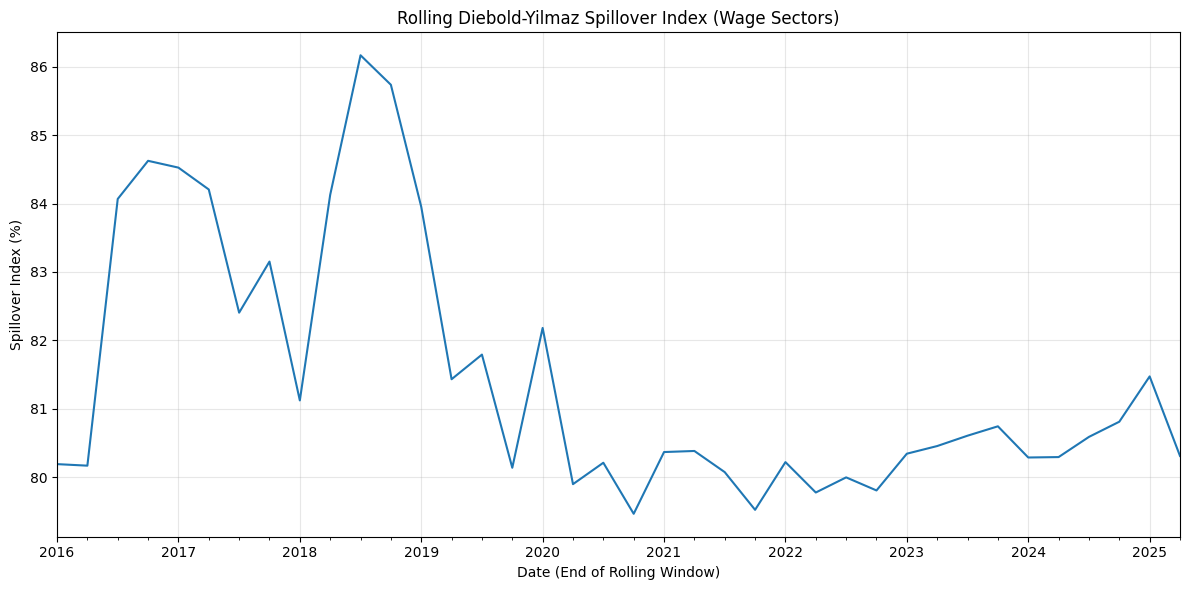

In [379]:
plt.figure(figsize=(12, 6))
dy_series_wages.plot()
plt.title("Rolling Diebold-Yilmaz Spillover Index (Wage Sectors)")
plt.ylabel("Spillover Index (%)")
plt.xlabel("Date (End of Rolling Window)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [380]:
labels_wages = df_wages_logdiff.columns.tolist()
latest_fevd_wages = fevd_matrices_wages[-1]

<ipython-input-381-1911f8c731db>:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


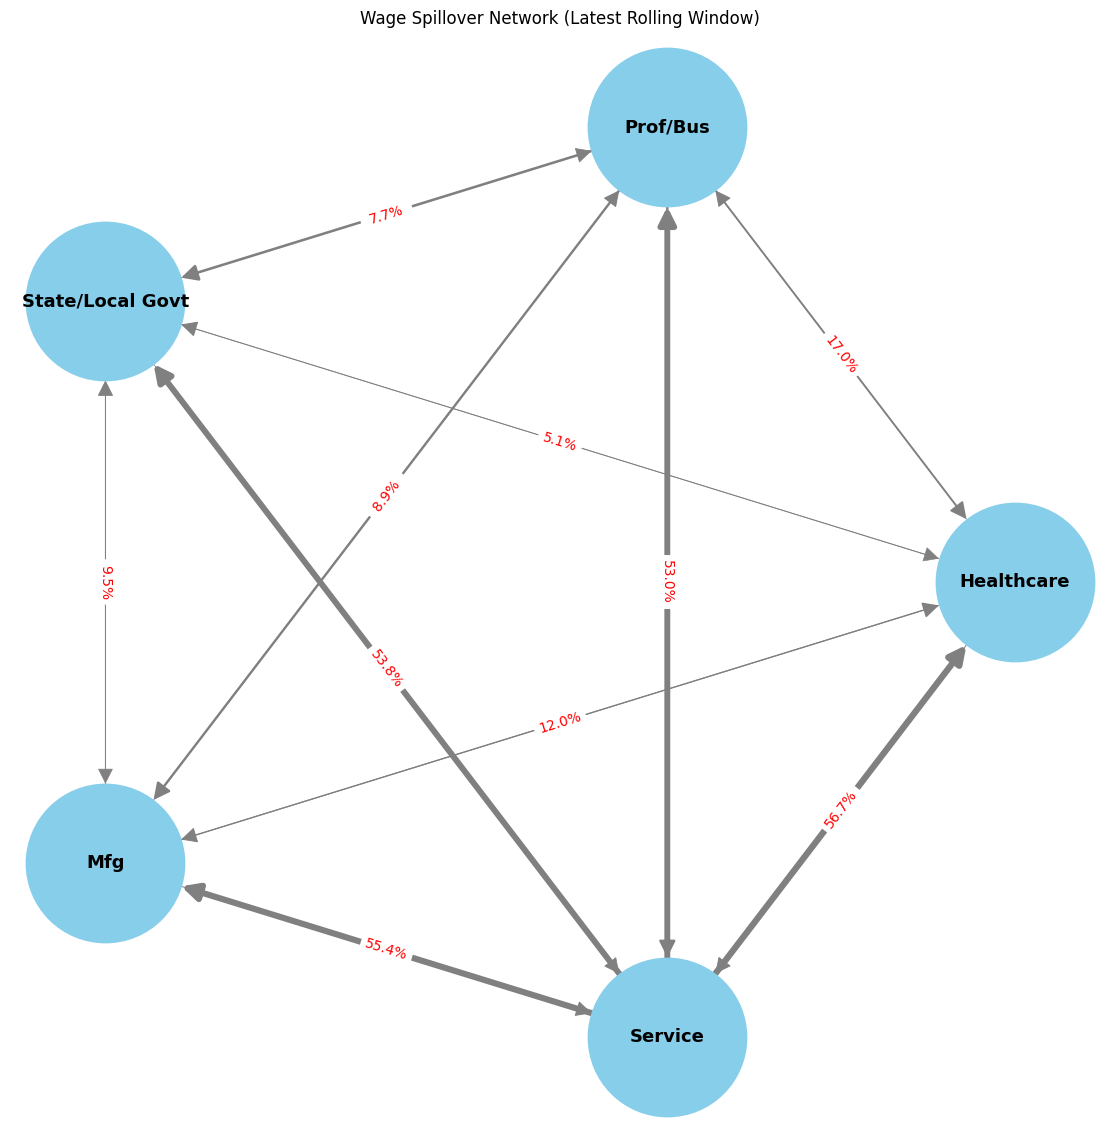

In [381]:
def plot_spillover_network(fevd, labels, threshold=0.02):
    import networkx as nx
    import matplotlib.pyplot as plt
    K = fevd.shape[0]
    G = nx.DiGraph()
    for i in range(K):
        G.add_node(labels[i])
    for i in range(K):
        for j in range(K):
            if i != j and fevd[i, j] >= threshold:
                G.add_edge(labels[j], labels[i], weight=fevd[i, j])
    weights = [G[u][v]['weight']*8 for u, v in G.edges()]
    pos = nx.circular_layout(G)
    plt.figure(figsize=(11, 11))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=13000, arrowsize=25,
            edge_color='gray', width=weights, font_size=13, font_weight='bold')
    edge_labels = {(u, v): f"{100*G[u][v]['weight']:.1f}%" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title("Wage Spillover Network (Latest Rolling Window)")
    plt.tight_layout()
    plt.show()

plot_spillover_network(latest_fevd_wages, labels_wages, threshold=0.03)

# Wage Gap Ratio

In [382]:
wage_gap_ratio = df_wages_real_q.max(axis=1) / df_wages_real_q.min(axis=1)

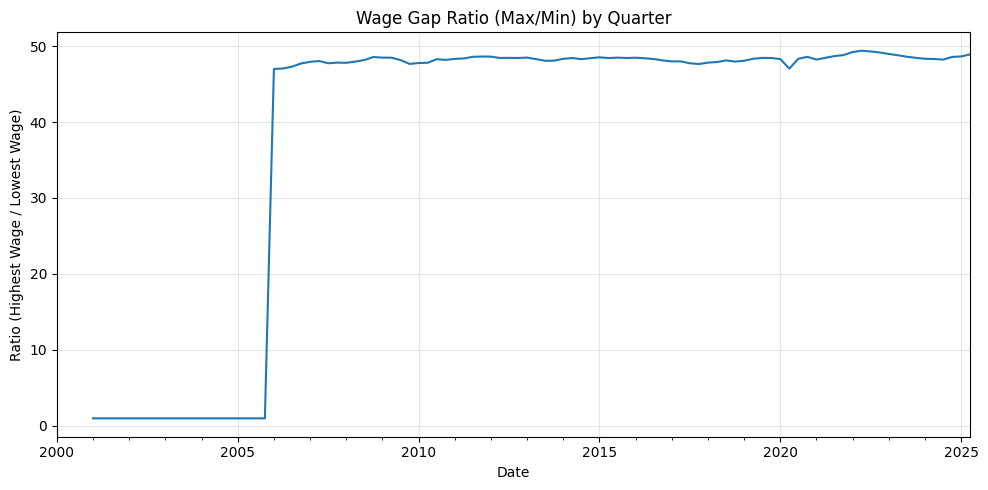

In [383]:
plt.figure(figsize=(10,5))
wage_gap_ratio.plot()
plt.title("Wage Gap Ratio (Max/Min) by Quarter")
plt.ylabel("Ratio (Highest Wage / Lowest Wage)")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [384]:
wage_max_sector = df_wages_real_q.idxmax(axis=1)
wage_min_sector = df_wages_real_q.idxmin(axis=1)

<ipython-input-384-27e2d61d9ec9>:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  wage_max_sector = df_wages_real_q.idxmax(axis=1)
<ipython-input-384-27e2d61d9ec9>:2: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  wage_min_sector = df_wages_real_q.idxmin(axis=1)


# Wage Growth

In [385]:
wage_qtrly_growth = df_wages_real_q.pct_change() * 100

In [386]:
wage_ann_growth = df_wages_real_q.pct_change(periods=4) * 100

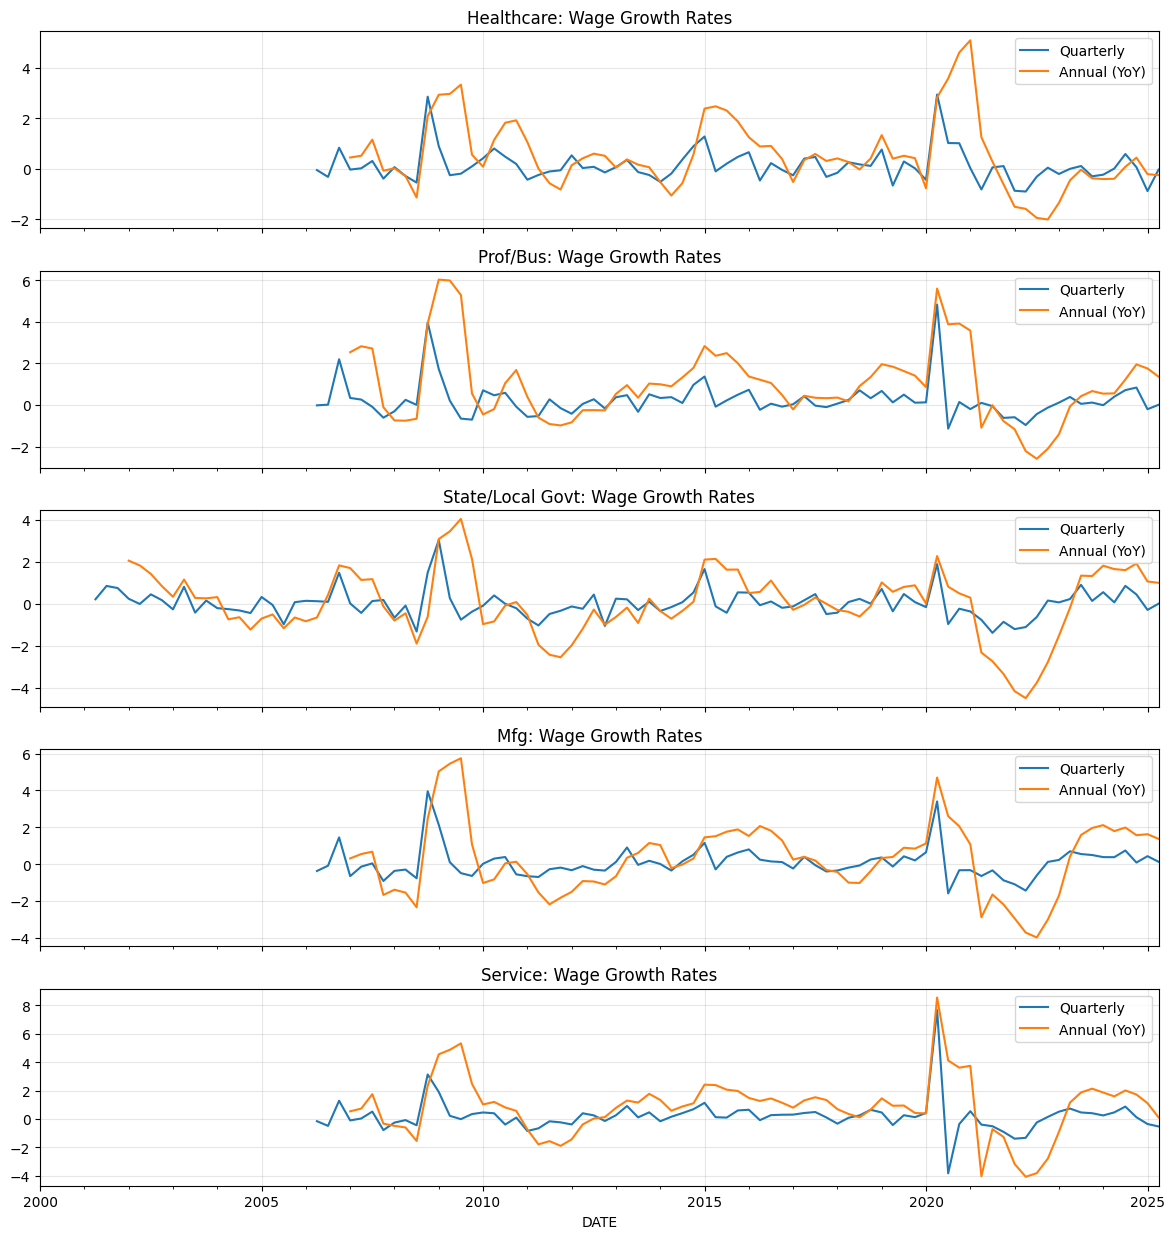

In [387]:
fig, axes = plt.subplots(df_wages_real_q.shape[1], 1, figsize=(12, 2.5*df_wages_real_q.shape[1]), sharex=True)
for i, col in enumerate(df_wages_real_q.columns):
    wage_qtrly_growth[col].plot(ax=axes[i], label="Quarterly")
    wage_ann_growth[col].plot(ax=axes[i], label="Annual (YoY)")
    axes[i].set_title(f"{col}: Wage Growth Rates")
    axes[i].legend()
    axes[i].grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Employment Growth

In [388]:
emp_qtrly_growth = df_q.pct_change() * 100

In [389]:
emp_ann_growth = df_q.pct_change(periods=4) * 100

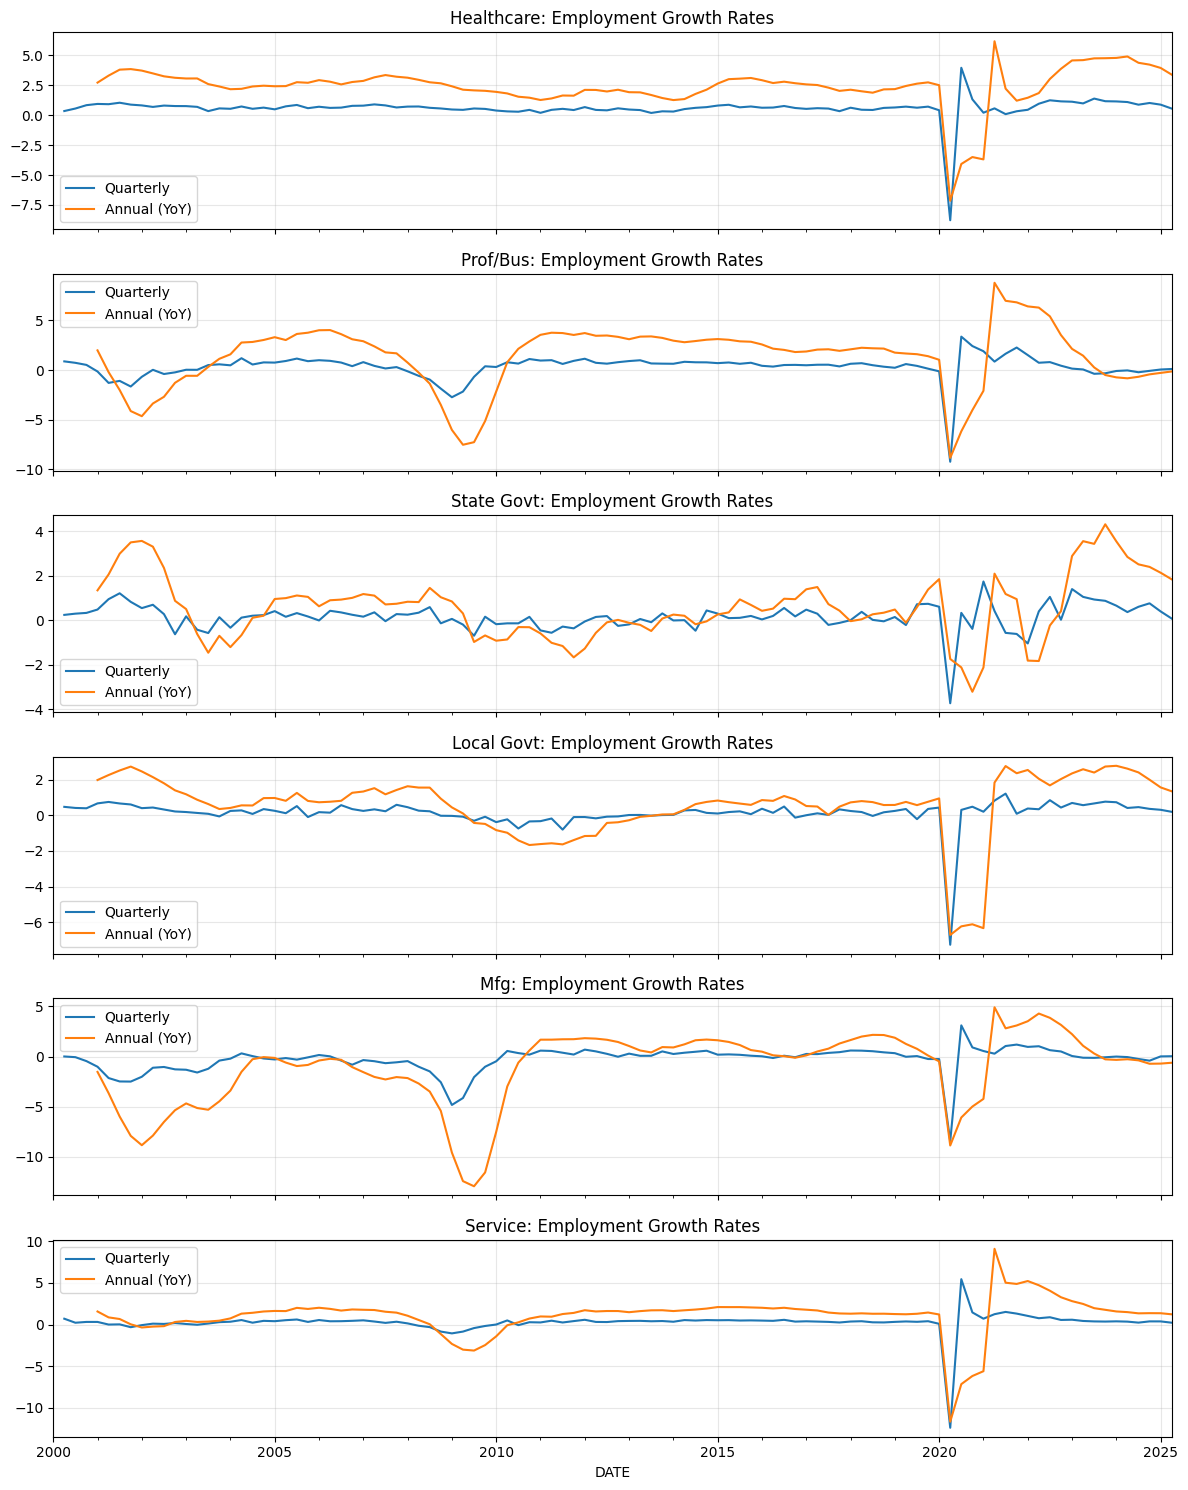

In [390]:
fig, axes = plt.subplots(df_q.shape[1], 1, figsize=(12, 2.5*df_q.shape[1]), sharex=True)
for i, col in enumerate(df_q.columns):
    emp_qtrly_growth[col].plot(ax=axes[i], label="Quarterly")
    emp_ann_growth[col].plot(ax=axes[i], label="Annual (YoY)")
    axes[i].set_title(f"{col}: Employment Growth Rates")
    axes[i].legend()
    axes[i].grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Employment CAGR

In [391]:
def compute_cagr(start, end, periods_per_year, total_periods):
    n_years = total_periods / periods_per_year
    return (end / start) ** (1/n_years) - 1

In [392]:
cagr_emp = {}
for col in df_q.columns:
    start = df_q[col].iloc[0]
    end = df_q[col].iloc[-1]
    total_periods = len(df_q)
    cagr_emp[col] = compute_cagr(start, end, periods_per_year=4, total_periods=total_periods) * 100  # in %

In [393]:
print("CAGR (Employment, 2000-2025):")
print(pd.Series(cagr_emp).round(2).astype(str) + ' %')

CAGR (Employment, 2000-2025):
Healthcare     2.37 %
Prof/Bus       1.23 %
State Govt     0.58 %
Local Govt     0.57 %
Mfg           -1.18 %
Service        1.01 %
dtype: object


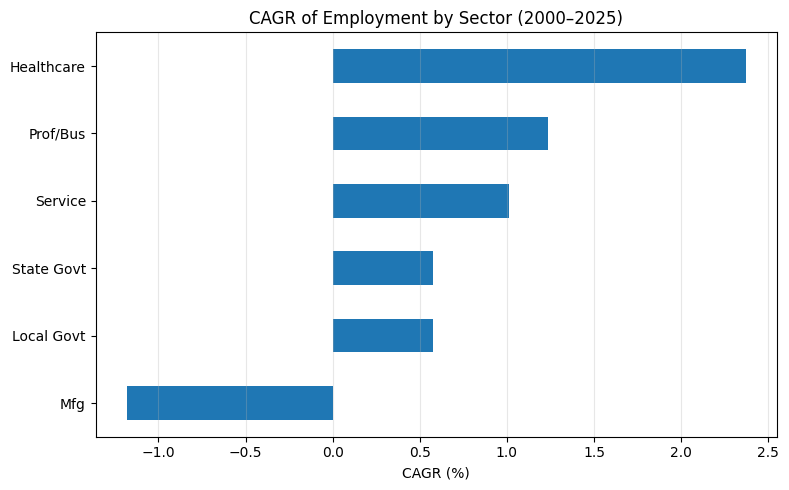

In [394]:
plt.figure(figsize=(8,5))
pd.Series(cagr_emp).sort_values().plot(kind='barh')
plt.title("CAGR of Employment by Sector (2000–2025)")
plt.xlabel("CAGR (%)")
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# BONUS: Top 5 Occupations by Employment

In [395]:
file_path = '/content/OES_Report (6).xlsx'
excel_file = pd.ExcelFile(file_path)
print(excel_file.sheet_names)

['OES Sheet']


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [396]:
df = pd.read_excel(file_path, sheet_name=excel_file.sheet_names[0])
print(df.head())

  Multiple occupations for one geographical area      Unnamed: 1  \
0                                            NaN             NaN   
1                                 Area: National             NaN   
2                               Period: May 2024             NaN   
3                                            NaN             NaN   
4                          Occupation (SOC code)  Employment (1)   

         Unnamed: 2            Unnamed: 3  
0               NaN                   NaN  
1               NaN                   NaN  
2               NaN                   NaN  
3               NaN                   NaN  
4  Hourly mean wage  Annual mean wage (2)  


In [397]:
# For example, if data starts at row 6 (index 5), use skiprows=5:
df = pd.read_excel(file_path, sheet_name=excel_file.sheet_names[0], skiprows=5)

# Set proper column names if needed
df.columns = ['Occupation', 'Employment', 'Hourly mean wage', 'Annual mean wage']

# Remove non-numeric rows in the Employment column
df = df[pd.to_numeric(df['Employment'], errors='coerce').notnull()]
df['Employment'] = df['Employment'].astype(int)


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [398]:
top5 = df.sort_values(by='Employment', ascending=False).head(5)
print(top5[['Occupation', 'Employment']])

                                           Occupation  Employment
0                            Top Executives (11-1000)     3822780
2           General and Operations Managers (11-1021)     3584420
24             Other Management Occupations (11-9000)     3352280
12          Operations Specialties Managers (11-3000)     2669000
4   Advertising, Marketing, Promotions, Public Rel...     1122770
